In [1]:
!pip install rasterio tqdm
import os
import rasterio
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Normalize, Resize
import matplotlib.pyplot as plt
from collections import Counter
class TifImageDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = [f for f in os.listdir(image_dir) if f.endswith(".tif")]
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
    # Load the image using rasterio
      img_name = self.image_names[idx]
      img_path = os.path.join(self.image_dir, img_name)
      with rasterio.open(img_path) as src:
          image = src.read()  # Read all bands

      # Convert image to PyTorch tensor
      image = torch.tensor(image, dtype=torch.float32)

      # Fix NaN values
      for band in range(image.shape[0]):  # Iterate over bands
          band_data = image[band, :, :]
          nan_mask = torch.isnan(band_data)
          if nan_mask.any():
              mean_value = band_data[~nan_mask].mean()  # Mean of non-NaN values
              band_data[nan_mask] = mean_value  # Replace NaN with the mean

      # Ensure 3-channel image for consistency
      if image.shape[0] == 3:
          pass
      elif image.shape[0] > 3:
          image = image[:3, :, :]
      else:
          image = image.expand(3, image.shape[1], image.shape[2])

      # Load the corresponding mask
      mask_name = img_name.replace(".tif", "_mask.tif")
      mask_path = os.path.join(self.mask_dir, mask_name)
      with rasterio.open(mask_path) as src:
          mask = src.read(1)  # Read single channel for binary mask

      # Calculate the number of zeros and non-zeros in the mask
      total_pixels = mask.size  # Total number of pixels in the mask
      non_zero_pixels = (mask > 0).sum()  # Count of non-zero pixels
      non_zero_percentage = (non_zero_pixels / total_pixels) * 100

      # Determine label based on non-zero percentage
      label = torch.tensor(1 if non_zero_percentage > 30 else 0, dtype=torch.long)

      # Apply transforms if provided
      if self.transform:
          image = self.transform(image)

      return image, label


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 8.6 MB/s eta 0:00:0000:0100:01mm


In [2]:
from torchvision.transforms import Compose, Normalize, Resize, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, ColorJitter,GaussianBlur

# Define transformations with augmentations
input_size = 224  # Required input size for ViT
transform = Compose([
    Resize((input_size, input_size)),            # Resize to ViT-compatible dimensions
    #RandomHorizontalFlip(p=0.5),                # Randomly flip images horizontally
    #RandomVerticalFlip(p=0.5),                  # Randomly flip images vertically
    #RandomRotation(degrees=15),                 # Randomly rotate images within ±15 degrees
    #GaussianBlur(kernel_size=(3, 3)),
    #ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color properties
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))     # ImageNet normalization
])

# Initialize dataset
image_dir = "/kaggle/input/sar-ds-r-filtered-bal/sar_ds_r_filtered_bal/image_patches"
mask_dir = "/kaggle/input/sar-ds-r-filtered-bal/sar_ds_r_filtered_bal/mask_patches"
dataset = TifImageDataset(image_dir=image_dir, mask_dir=mask_dir, transform=transform)

# Example to check output
for image, label in dataset:
    print(f"Image shape after processing: {image.shape}, Label: {label}")
    break

data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
for image, label in dataset:
    print(f"Image shape after processing: {image.shape}, Label: {label}")
    break
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
print(torch.cuda.is_available())
print(torch.version.cuda)

Image shape after processing: torch.Size([3, 224, 224]), Label: 1
Image shape after processing: torch.Size([3, 224, 224]), Label: 1
True
12.1


In [ ]:
import os
import pickle
import torch
from collections import Counter
from torchvision import models
from tqdm import tqdm
from timm import create_model
from torch import nn, optim
from sklearn.metrics import precision_score, recall_score, f1_score, mean_absolute_error
import pandas as pd


model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_classes = 2  # Binary classification
model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, num_classes),
    torch.nn.Sigmoid()
)

# Enable DataParallel for multi-GPU support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs...")
    model = torch.nn.DataParallel(model)

model.to(device)

# Check class distribution
class_counts = Counter(label.item() for _, label in dataset)
print(f"Class distribution: {class_counts}")

class_weights = torch.tensor([1.0, len(dataset) / class_counts[1]], device=device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)

# Initialize lists to store metrics
metrics_history = []
checkpoint_dir = ""
#os.makedirs(checkpoint_dir, exist_ok=True)  # Create directory if it doesn't exist
metrics_csv_path = os.path.join(checkpoint_dir, "metrics_history_bal_40_L.csv")

best_accuracy = 0.0  # To track the best model

# Training loop with checkpoint saving
epochs = 15
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    # Initialize progress bar for the current epoch
    progress_bar = tqdm(enumerate(data_loader), total=len(data_loader), desc=f"Epoch {epoch + 1}/{epochs}")

    for batch_idx, (images, labels) in progress_bar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        # Calculate batch metrics
        batch_loss = loss.item()
        batch_accuracy = 100 * (predicted == labels).sum().item() / labels.size(0)

        progress_bar.set_postfix({
            "Batch Loss": f"{batch_loss:.4f}",
            "Batch Accuracy": f"{batch_accuracy:.2f}%",
            "Epoch Loss": f"{running_loss / (batch_idx + 1):.4f}",
            "Epoch Accuracy": f"{100 * correct / total:.2f}%"
        })

    # Compute additional metrics
    epoch_loss = running_loss / len(data_loader)
    epoch_accuracy = 100 * correct / total
    epoch_precision = precision_score(all_labels, all_predictions, average='weighted')
    epoch_recall = recall_score(all_labels, all_predictions, average='weighted')
    epoch_f1 = f1_score(all_labels, all_predictions, average='weighted')
    epoch_mae = mean_absolute_error(all_labels, all_predictions)

    # Save metrics
    metrics_history.append({
        "epoch": epoch + 1,
        "loss": epoch_loss,
        "accuracy": epoch_accuracy,
        "precision": epoch_precision,
        "recall": epoch_recall,
        "f1_score": epoch_f1,
        "mae": epoch_mae
    })

    # Write metrics to CSV
    metrics_df = pd.DataFrame(metrics_history)
    metrics_df.to_csv(metrics_csv_path, index=False)

    print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Precision: {epoch_precision:.2f}, Recall: {epoch_recall:.2f}, F1 Score: {epoch_f1:.2f}, MAE: {epoch_mae:.2f}")

    # Save the best model
    if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
        best_model_path = os.path.join(checkpoint_dir, "best_model_bal_40_L.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            'accuracy': epoch_accuracy,
        }, best_model_path)
        print(f"Best model updated with accuracy: {best_accuracy:.2f}%")

print("Training complete. Checkpoints and metrics saved.")


Using 2 GPUs...
Class distribution: {1: 3496, 0: 3496}


Epoch 1/15: 100%|██████████| 219/219 [01:36<00:00,  2.26it/s, Batch Loss=0.7088, Batch Accuracy=25.00%, Epoch Loss=0.6969, Epoch Accuracy=50.80%]


Epoch [1/15] - Loss: 0.6969, Accuracy: 50.80%, Precision: 0.51, Recall: 0.51, F1 Score: 0.45, MAE: 0.49
Best model updated with accuracy: 50.80%


Epoch 2/15: 100%|██████████| 219/219 [01:36<00:00,  2.27it/s, Batch Loss=0.6961, Batch Accuracy=50.00%, Epoch Loss=0.6954, Epoch Accuracy=53.65%]


Epoch [2/15] - Loss: 0.6954, Accuracy: 53.65%, Precision: 0.56, Recall: 0.54, F1 Score: 0.49, MAE: 0.46
Best model updated with accuracy: 53.65%


Epoch 3/15: 100%|██████████| 219/219 [01:36<00:00,  2.27it/s, Batch Loss=0.6945, Batch Accuracy=56.25%, Epoch Loss=0.6939, Epoch Accuracy=54.73%]


Epoch [3/15] - Loss: 0.6939, Accuracy: 54.73%, Precision: 0.56, Recall: 0.55, F1 Score: 0.51, MAE: 0.45
Best model updated with accuracy: 54.73%


Epoch 4/15: 100%|██████████| 219/219 [01:37<00:00,  2.25it/s, Batch Loss=0.6889, Batch Accuracy=62.50%, Epoch Loss=0.6924, Epoch Accuracy=58.32%]


Epoch [4/15] - Loss: 0.6924, Accuracy: 58.32%, Precision: 0.60, Recall: 0.58, F1 Score: 0.56, MAE: 0.42
Best model updated with accuracy: 58.32%


Epoch 5/15: 100%|██████████| 219/219 [01:36<00:00,  2.27it/s, Batch Loss=0.6912, Batch Accuracy=68.75%, Epoch Loss=0.6912, Epoch Accuracy=59.61%]


Epoch [5/15] - Loss: 0.6912, Accuracy: 59.61%, Precision: 0.61, Recall: 0.60, F1 Score: 0.58, MAE: 0.40
Best model updated with accuracy: 59.61%


Epoch 6/15: 100%|██████████| 219/219 [01:37<00:00,  2.25it/s, Batch Loss=0.6842, Batch Accuracy=81.25%, Epoch Loss=0.6893, Epoch Accuracy=63.36%]


Epoch [6/15] - Loss: 0.6893, Accuracy: 63.36%, Precision: 0.64, Recall: 0.63, F1 Score: 0.63, MAE: 0.37
Best model updated with accuracy: 63.36%


Epoch 7/15: 100%|██████████| 219/219 [01:36<00:00,  2.26it/s, Batch Loss=0.6887, Batch Accuracy=62.50%, Epoch Loss=0.6879, Epoch Accuracy=65.05%]


Epoch [7/15] - Loss: 0.6879, Accuracy: 65.05%, Precision: 0.66, Recall: 0.65, F1 Score: 0.65, MAE: 0.35
Best model updated with accuracy: 65.05%


Epoch 8/15: 100%|██████████| 219/219 [01:36<00:00,  2.27it/s, Batch Loss=0.6840, Batch Accuracy=62.50%, Epoch Loss=0.6865, Epoch Accuracy=66.16%]


Epoch [8/15] - Loss: 0.6865, Accuracy: 66.16%, Precision: 0.66, Recall: 0.66, F1 Score: 0.66, MAE: 0.34
Best model updated with accuracy: 66.16%


Epoch 9/15: 100%|██████████| 219/219 [01:36<00:00,  2.27it/s, Batch Loss=0.6898, Batch Accuracy=68.75%, Epoch Loss=0.6852, Epoch Accuracy=68.52%]


Epoch [9/15] - Loss: 0.6852, Accuracy: 68.52%, Precision: 0.69, Recall: 0.69, F1 Score: 0.69, MAE: 0.31
Best model updated with accuracy: 68.52%


Epoch 10/15: 100%|██████████| 219/219 [01:35<00:00,  2.29it/s, Batch Loss=0.6840, Batch Accuracy=68.75%, Epoch Loss=0.6835, Epoch Accuracy=70.34%]


Epoch [10/15] - Loss: 0.6835, Accuracy: 70.34%, Precision: 0.70, Recall: 0.70, F1 Score: 0.70, MAE: 0.30
Best model updated with accuracy: 70.34%


Epoch 11/15: 100%|██████████| 219/219 [01:36<00:00,  2.27it/s, Batch Loss=0.6817, Batch Accuracy=75.00%, Epoch Loss=0.6816, Epoch Accuracy=70.97%]


Epoch [11/15] - Loss: 0.6816, Accuracy: 70.97%, Precision: 0.71, Recall: 0.71, F1 Score: 0.71, MAE: 0.29
Best model updated with accuracy: 70.97%


Epoch 12/15: 100%|██████████| 219/219 [01:37<00:00,  2.25it/s, Batch Loss=0.6898, Batch Accuracy=68.75%, Epoch Loss=0.6802, Epoch Accuracy=73.00%]


Epoch [12/15] - Loss: 0.6802, Accuracy: 73.00%, Precision: 0.74, Recall: 0.73, F1 Score: 0.73, MAE: 0.27
Best model updated with accuracy: 73.00%


Epoch 13/15: 100%|██████████| 219/219 [01:36<00:00,  2.27it/s, Batch Loss=0.6808, Batch Accuracy=75.00%, Epoch Loss=0.6783, Epoch Accuracy=73.76%]


Epoch [13/15] - Loss: 0.6783, Accuracy: 73.76%, Precision: 0.75, Recall: 0.74, F1 Score: 0.73, MAE: 0.26
Best model updated with accuracy: 73.76%


Epoch 14/15: 100%|██████████| 219/219 [01:36<00:00,  2.27it/s, Batch Loss=0.6820, Batch Accuracy=75.00%, Epoch Loss=0.6766, Epoch Accuracy=73.63%]


Epoch [14/15] - Loss: 0.6766, Accuracy: 73.63%, Precision: 0.75, Recall: 0.74, F1 Score: 0.73, MAE: 0.26


Epoch 15/15: 100%|██████████| 219/219 [01:37<00:00,  2.25it/s, Batch Loss=0.6736, Batch Accuracy=93.75%, Epoch Loss=0.6749, Epoch Accuracy=74.46%]


Epoch [15/15] - Loss: 0.6749, Accuracy: 74.46%, Precision: 0.77, Recall: 0.74, F1 Score: 0.74, MAE: 0.26
Best model updated with accuracy: 74.46%
Training complete. Checkpoints and metrics saved.


In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.models as models

# Step 1: Define Model and Load Weights
# Step 4: Load Pre-trained ViT Model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_classes = 2  # Binary classification
model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, num_classes),
    torch.nn.Sigmoid()
)

# Enable DataParallel for multi-GPU support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs...")
    model = torch.nn.DataParallel(model)

model.to(device)
from collections import OrderedDict 
#models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
checkpoint_path = "/kaggle/working/best_model_bal_40_L.pth"  # Replace with the desired epoch checkpoint file
checkpoint = torch.load(checkpoint_path, map_location=device,weights_only=True)
state_dict = checkpoint['model_state_dict']

# Remove 'module.' prefix from state dict keys if present
new_state_dict = OrderedDict()
for key, value in state_dict.items():
    new_key = key.replace("module.", "")
    new_state_dict[new_key] = value

# Load the modified state dict into the model
model.load_state_dict(state_dict)
model.eval()  # Set model to evaluation mode

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:05<00:00, 20.0MB/s]


Using 2 GPUs...


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

Confusion Matrix:
[[2273 1223]
 [ 362 3134]]

Classification Report:
              precision    recall  f1-score   support

no oil spill       0.86      0.65      0.74      3496
   oil spill       0.72      0.90      0.80      3496

    accuracy                           0.77      6992
   macro avg       0.79      0.77      0.77      6992
weighted avg       0.79      0.77      0.77      6992

Precision: 0.72
Recall (Sensitivity, TPR): 0.90
F1 Score: 0.80
Cohen's Kappa: 0.55
True Positive Rate (TPR): 0.90
True Negative Rate (TNR): 0.65
False Positive Rate (FPR): 0.35
False Negative Rate (FNR): 0.10


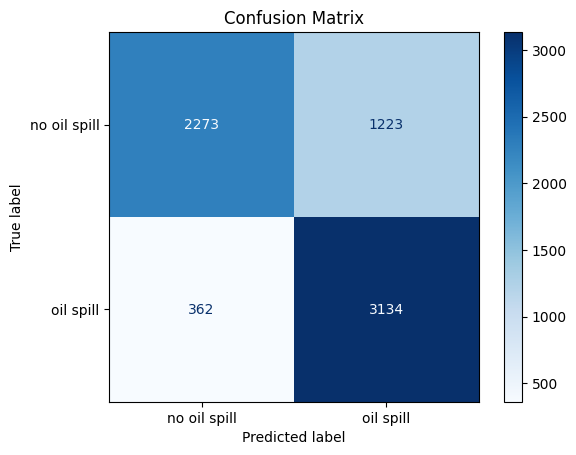

In [5]:
import torch
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score,
    classification_report
)
import matplotlib.pyplot as plt

# Step 2: Evaluate and Collect Predictions
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient computation
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted class
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Step 3: Generate Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = ['no oil spill', 'oil spill']  # Replace with your class names if needed

# Extract True Positives (TP), False Positives (FP), True Negatives (TN), False Negatives (FN)
TP = cm[1, 1]
FP = cm[0, 1]
TN = cm[0, 0]
FN = cm[1, 0]

# Metrics Calculations
precision = precision_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
f1 = f1_score(all_labels, all_preds, average='binary')
kappa = cohen_kappa_score(all_labels, all_preds)
TPR = TP / (TP + FN) if (TP + FN) > 0 else 0  # True Positive Rate (Sensitivity)
TNR = TN / (TN + FP) if (TN + FP) > 0 else 0  # True Negative Rate (Specificity)
FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  # False Positive Rate
FNR = FN / (FN + TP) if (FN + TP) > 0 else 0  # False Negative Rate

# Display Metrics
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity, TPR): {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Cohen's Kappa: {kappa:.2f}")
print(f"True Positive Rate (TPR): {TPR:.2f}")
print(f"True Negative Rate (TNR): {TNR:.2f}")
print(f"False Positive Rate (FPR): {FPR:.2f}")
print(f"False Negative Rate (FNR): {FNR:.2f}")

# Step 4: Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
